In [205]:
#!pip install yfinance
#!pip install pytickersymbols

In [206]:
import yfinance
import pandas as pd
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
from pytickersymbols import PyTickerSymbols
from datetime import datetime, timedelta

In [207]:
# industries = stock_data.get_all_industries()
# industries

In [208]:
# stock_data = PyTickerSymbols()
# syp = pd.DataFrame(stock_data.get_stocks_by_index('S&P 500'))

In [209]:
# stocks_tech = []
# for i in range(len(syp)):
#   for j in range(len(syp['industries'][i])):
#     if syp['industries'][i][j] == 'Technology' or syp['industries'][i][j] == 'NASDAQ 100':
#       stocks_tech.append(syp.symbol[i])

In [210]:
#APLICANDO ETF'S
stocks_tech = ['PEP', 'KO']

#['JMP', 'OPY'], ['PEP', 'KO'], ['PCG', 'WEC'], ['PCG', 'UTL'], ['ED', 'DUK'], ['PCG', 'XEL'], ['WEC', 'XEL'], ['NTAP', 'RADA']
#['TAIT', 'IIVI']***, ['TAIT', 'ITRN']***, ['QBAK', 'ITRN'], ['QBAK', 'AVT']

In [211]:
mv_avg = 20
factor = .1 #Factor +- para los spreads
cash=2500 #por Trade
#period

In [212]:
d = pd.DataFrame([])
d_open = pd.DataFrame([])
for j in range(len(stocks_tech)):

  d.insert(j,stocks_tech[j], yfinance.download(stocks_tech[j],period='10y')['Close'])
  d_open.insert(j,stocks_tech[j], yfinance.download(stocks_tech[j],period='10y')['Open'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [213]:
#DF DE LOS MOVING AVERAGE DE LAS ACCIONES
d_mv_avg = d.rolling(mv_avg).mean().dropna()#[-5:]
d_mv_avg.head(3)

,PEP,KO
Date,,
2011-03-14,63.7160,32.23125
2011-03-15,63.6995,32.22850
2011-03-16,63.5975,32.18875


In [214]:
#DF DE LOS PRECIOS CON LOS QUE ABRIERON CADA DÍA
d_open.rolling(mv_avg).mean().dropna()#[-5:]
d_open = d_open.loc[d_mv_avg.index[0].strftime('%Y-%m-%d'):d_mv_avg.index[-1].strftime('%Y-%m-%d')]
d_open.head(3)

,PEP,KO
Date,,
2011-03-14,64.260002,32.169998
2011-03-15,63.439999,31.475000
2011-03-16,62.889999,31.344999


In [215]:
#DF DE LOS PRECIOS CON LOS QUE CERRARON CADA DÍA
d_actuales = d.loc[d_mv_avg.index[0].strftime('%Y-%m-%d'):d_mv_avg.index[-1].strftime('%Y-%m-%d')]#[-5:]
d_actuales.head(3)

,PEP,KO
Date,,
2011-03-14,64.139999,31.969999
2011-03-15,63.009998,31.514999
2011-03-16,62.310001,30.799999


In [216]:
# print((d_mv_avg.iloc[-1,1]-d_mv_avg.iloc[-1,4])*(1+factor))
# print(d_mv_avg.iloc[-1,1]-d_mv_avg.iloc[-1,4])
# print((d_mv_avg.iloc[-1,1]-d_mv_avg.iloc[-1,4])*(1-factor))

In [217]:
titulos = d.columns.values[0:].tolist()

In [218]:
%%time

iteraciones = 0
greens = 0
reds = 0
PL = 0
    
for h in range(1,len(d_actuales)):
  posiciones = []
  for j in range(0,len(d_actuales.iloc[h-1])):
    
    for i in range(0,len(titulos)):
      #Condición de que el par no sean el mismo símbolo, y de que no se repita el par (e.g. AAPL - CSCO y CSCO - AAPL)
      if titulos[j] != titulos[i] and i+j <= len(titulos): #and titulos[i] not in posiciones:
        spread_curr = d_actuales.iloc[h-1][j]-d_actuales.iloc[h-1][i]
        spread_avg = d_mv_avg.iloc[h-1][j]-d_mv_avg.iloc[h-1][i]

        spread_alto = spread_avg * (1+factor)
        spread_bajo = spread_avg * (1-factor)

        iteraciones = iteraciones + 1
        #CONDICION EN LA QUE EL SPREAD DE LOS MOVING AVERAGES ES POSITIVO
        if spread_avg > 0:
          num_shares_j = cash//d_open.iloc[h,j]
          num_shares_i = cash//d_open.iloc[h,i]
          if spread_curr > spread_alto:
            compra = num_shares_i*(d_actuales.iloc[h,i]-d_open.iloc[h,i])
            short = num_shares_j*(d_open.iloc[h,j]-d_actuales.iloc[h,j])
            if compra >= 0 and titulos[i] not in posiciones: 
              greens = greens + 1
              PL = PL + compra
              posiciones.append(titulos[i])
            elif titulos[i] not in posiciones: 
              reds = reds + 1 
              PL = PL + compra
              posiciones.append(titulos[i])
            if short >= 0 and titulos[j] not in posiciones: 
              greens = greens +1
              PL = PL + short
              posiciones.append(titulos[j])
            elif titulos[j] not in posiciones: 
              reds = reds + 1
              PL = PL + short
              posiciones.append(titulos[j])
            print(d_mv_avg.index[h-1].strftime('%Y-%m-%d'), 'Spread Positivo de:',  spread_curr, '; Short:', titulos[j], 'y Compra:', titulos[i])
            print('RESULTADOS: Short', short, 'Compra', compra)
          elif spread_curr < spread_bajo:
            compra = num_shares_j*(d_actuales.iloc[h,j]-d_open.iloc[h,j])
            short = num_shares_i*(d_open.iloc[h,i]-d_actuales.iloc[h,i])
            if compra >= 0 and titulos[j] not in posiciones: 
              greens = greens + 1
              PL = PL + compra
              posiciones.append(titulos[j])
            elif titulos[j] not in posiciones: 
              reds = reds + 1 
              PL = PL + compra
              posiciones.append(titulos[j])
            if short >= 0 and titulos[i] not in posiciones: 
              greens = greens +1
              PL = PL + short
              posiciones.append(titulos[i])
            elif titulos[i] not in posiciones: 
              reds = reds + 1
              PL = PL + short
              posiciones.append(titulos[i])
            print(d_mv_avg.index[h-1].strftime('%Y-%m-%d'), 'Spread Positivo de:',  spread_curr, '; Compra:', titulos[j], 'y Short:', titulos[i])
            print('RESULTADOS: Compra', compra, 'Short', short)

        #CONDICION EN LA QUE EL SPREAD DE LOS MOVING AVERAGES ES NEGATIVO (CAMBIAN LOS VALORES CON FACTORES)
        elif spread_avg < 0:
          num_shares_j = cash//d_open.iloc[h,j]
          num_shares_i = cash//d_open.iloc[h,i]
          if spread_curr < spread_alto:
            compra = num_shares_j*(d_actuales.iloc[h,j]-d_open.iloc[h,j])
            short = num_shares_i*(d_open.iloc[h,i]-d_actuales.iloc[h,i])
            if compra >= 0 and titulos[j] not in posiciones: 
              greens = greens + 1
              PL = PL + compra
              posiciones.append(titulos[j])
            elif titulos[j] not in posiciones: 
              reds = reds + 1 
              PL = PL + compra
              posiciones.append(titulos[j])
            if short >= 0 and titulos[i] not in posiciones: 
              greens = greens +1
              PL = PL + short
              posiciones.append(titulos[i])
            elif titulos[i] not in posiciones: 
              reds = reds + 1
              PL = PL + short
              posiciones.append(titulos[i])
            print(d_mv_avg.index[h-1].strftime('%Y-%m-%d'), 'Spread Negativo de:',  spread_curr, '; Compra:', titulos[j], 'y Short:', titulos[i])
            print('RESULTADOS: Compra', compra, 'Short', short)
          elif spread_curr > spread_bajo:
            compra = num_shares_i*(d_actuales.iloc[h,i]-d_open.iloc[h,i])
            short = num_shares_j*(d_open.iloc[h,j]-d_actuales.iloc[h,j])
            if compra >= 0 and titulos[i] not in posiciones: 
              greens = greens + 1
              PL = PL + compra
              posiciones.append(titulos[i])
            elif titulos[i] not in posiciones: 
              reds = reds + 1 
              PL = PL + compra
              posiciones.append(titulos[i])
            if short >= 0 and titulos[j] not in posiciones: 
              greens = greens +1
              PL = PL + short
              posiciones.append(titulos[j])
            elif titulos[j] not in posiciones: 
              reds = reds + 1
              PL = PL + short
              posiciones.append(titulos[j])
            print(d_mv_avg.index[h-1].strftime('%Y-%m-%d'), 'Spread Negativo de:',  spread_curr, '; Short:', titulos[j], 'y Compra:', titulos[i])
            print('RESULTADOS: Short', short, 'Compra', compra)    

2011-07-21 Spread Positivo de: 31.5 ; Compra: PEP y Short: KO
RESULTADOS: Compra -15.539932250976562 Short -6.390010833740234
2011-07-21 Spread Negativo de: -31.5 ; Short: KO y Compra: PEP
RESULTADOS: Short -6.390010833740234 Compra -15.539932250976562
2011-07-22 Spread Positivo de: 30.895000457763672 ; Compra: PEP y Short: KO
RESULTADOS: Compra -31.539779663085938 Short -5.03997802734375
2011-07-22 Spread Negativo de: -30.895000457763672 ; Short: KO y Compra: PEP
RESULTADOS: Short -5.03997802734375 Compra -31.539779663085938
2011-07-25 Spread Positivo de: 29.740001678466797 ; Compra: PEP y Short: KO
RESULTADOS: Compra -22.040069580078125 Short 5.759857177734375
2011-07-25 Spread Negativo de: -29.740001678466797 ; Short: KO y Compra: PEP
RESULTADOS: Short 5.759857177734375 Compra -22.040069580078125
2011-07-26 Spread Positivo de: 29.474998474121094 ; Compra: PEP y Short: KO
RESULTADOS: Compra -8.969833374023438 Short 2.879791259765625
2011-07-26 Spread Negativo de: -29.474998474121094 

In [219]:
iteraciones

4994

In [220]:
print(greens)
print(reds)
print(PL)

24
22
503.9195861816406


**VERSION 2, UTILIZANDO EL RATIO DE LOS PRECIOS Y TRIGGER STD DE 2**

In [221]:
#APLICANDO ETF'S
stocks_tech = ['PEP', 'KO']

# stocks_tech = [['JMP', 'OPY'], ['PEP', 'KO'], ['PCG', 'WEC'], ['PCG', 'UTL'], ['ED', 'DUK'], ['PCG', 'XEL'], ['WEC', 'XEL'], ['NTAP', 'RADA'],
# ['TAIT', 'IIVI'], ['TAIT', 'ITRN'], ['QBAK', 'ITRN'], ['QBAK', 'AVT']]

In [222]:
import numpy as np

cash=2500 #por Trade
multiplier = 2 #STD
period = 20 #días para mvg y std

In [230]:
d_ratios = pd.DataFrame([])
d_close = pd.DataFrame([])

for i in range(len(stocks_tech)):
    d_ratios.insert(i,stocks_tech[i], yfinance.download(stocks_tech[i],period='60d', interval='15m')['Open'])
    d_close.insert(i,stocks_tech[i], yfinance.download(stocks_tech[i],period='60d', interval='15m')['Close'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
d_ratios['ratio'] = d_ratios['PEP']/d_ratios['KO']
d_ratios['ratio_mvg'] = d_ratios['ratio'].rolling(period).mean()
d_ratios.dropna()
d_ratios['Upper_T'] = d_ratios['ratio'].rolling(period).mean() + d_ratios['ratio'].rolling(period).std() * multiplier
d_ratios['Lower_T'] = d_ratios['ratio'].rolling(period).mean() - d_ratios['ratio'].rolling(period).std() * multiplier

d_ratios['Trigger'] = 0
d_ratios['Green_i'] = 0
d_ratios['Green_j'] = 0
d_ratios['Red_i'] = 0
d_ratios['Red_j'] = 0

PL_i = 0
PL_j = 0
closed = 0

for i in range(len(d_ratios)):
  num_shares_i = cash//d_ratios['PEP'][i]
  num_shares_j = cash//d_ratios['KO'][i]
  if d_ratios['ratio'][i] > d_ratios['Upper_T'][i]:
    short = num_shares_i*(d_ratios['PEP'][i]-d_close['PEP'][i])
    compra = num_shares_j*(d_close['KO'][i]-d_ratios['KO'][i])
    d_ratios['Trigger'][i] = True
    if compra > 0:
      d_ratios['Green_i'][i] = 1
      PL += compra
    else:
      d_ratios['Red_i'][i] = 1
      PL += compra
    if short > 0:
      d_ratios['Green_j'][i] = 1
      PL += short
    else:
      d_ratios['Red_j'][i] = 1
      PL += short

  elif d_ratios['ratio'][i] < d_ratios['Lower_T'][i]:
    compra = num_shares_i*(d_close['PEP'][i]-d_ratios['PEP'][i])
    short = num_shares_j*(d_ratios['KO'][i]-d_close['KO'][i])
    d_ratios['Trigger'][i] = True
    if compra > 0:
      d_ratios['Green_i'][i] = 1
      PL += compra
    else:
      d_ratios['Red_i'][i] = 1
      PL += compra
    if short > 0:
      d_ratios['Green_j'][i] = 1
      PL += short
    else:
      d_ratios['Red_j'][i] = 1
      PL += short

In [232]:
d_ratios

,PEP,KO,ratio,ratio_mvg,Upper_T,Lower_T,Trigger,Green_i,Green_j,Red_i,Red_j
Datetime,,,,,,,,,,,
2020-11-17 09:30:00-05:00,144.270004,53.660000,2.688595,NaN,NaN,NaN,0,0,0,0,0
2020-11-17 09:45:00-05:00,144.470001,53.330002,2.708982,NaN,NaN,NaN,0,0,0,0,0
2020-11-17 10:00:00-05:00,144.630005,53.244999,2.716312,NaN,NaN,NaN,0,0,0,0,0
2020-11-17 10:15:00-05:00,144.330002,53.060001,2.720128,NaN,NaN,NaN,0,0,0,0,0
2020-11-17 10:30:00-05:00,144.229996,53.189999,2.711600,NaN,NaN,NaN,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-12 14:45:00-05:00,133.759995,50.535000,2.646878,2.651330,2.661091,2.641569,0,0,0,0,0
2021-02-12 15:00:00-05:00,133.713501,50.595001,2.642820,2.650929,2.661407,2.640451,0,0,0,0,0
2021-02-12 15:15:00-05:00,133.875000,50.660000,2.642617,2.649918,2.659415,2.640421,0,0,0,0,0


In [233]:
print(d_ratios['Trigger'].sum()*2)
print(d_ratios['Green_i'].sum())
print(d_ratios['Green_j'].sum())
print(d_ratios['Red_i'].sum())
print(d_ratios['Red_j'].sum())

328
78
95
86
69


In [234]:
PL

164.68725204467773

In [235]:
d_ratios[d_ratios['Trigger']==1]

,PEP,KO,ratio,ratio_mvg,Upper_T,Lower_T,Trigger,Green_i,Green_j,Red_i,Red_j
Datetime,,,,,,,,,,,
2020-11-18 15:00:00-05:00,144.679993,52.895302,2.735214,2.719280,2.733334,2.705226,1,1,1,0,0
2020-11-19 13:30:00-05:00,143.139999,52.750000,2.713554,2.723028,2.731750,2.714306,1,0,1,1,0
2020-11-19 13:45:00-05:00,143.025803,52.750000,2.711390,2.722273,2.732257,2.712290,1,0,1,1,0
2020-11-19 14:45:00-05:00,143.169998,52.980000,2.702340,2.719684,2.733859,2.705510,1,1,0,0,1
2020-11-19 15:00:00-05:00,143.210007,53.095001,2.697241,2.718457,2.735768,2.701145,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-11 10:00:00-05:00,136.250000,50.075001,2.720919,2.759337,2.785280,2.733395,1,0,0,1,1
2021-02-11 10:15:00-05:00,136.020004,50.278900,2.705310,2.756313,2.791529,2.721096,1,1,0,0,1
2021-02-11 10:30:00-05:00,136.335007,50.341599,2.708198,2.753738,2.794936,2.712540,1,1,1,0,0


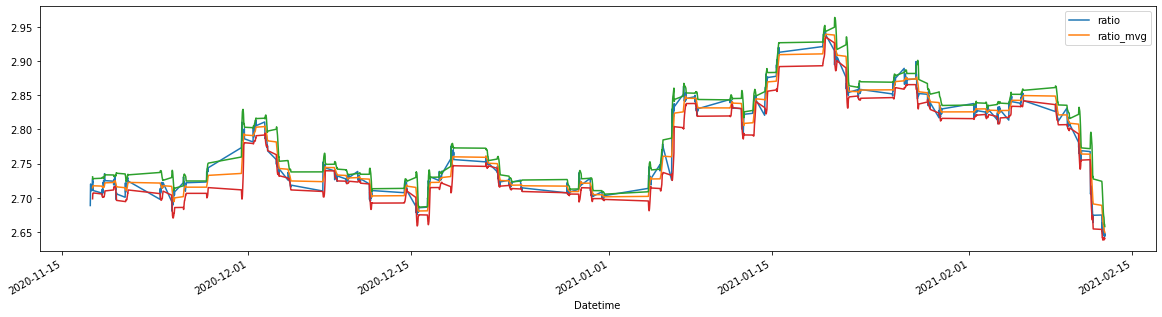

In [236]:
size= (20,5)
d_ratios['ratio'].plot(figsize=size, legend='ratio')
d_ratios['ratio_mvg'].plot(figsize=size, legend='ratio_mvg')
d_ratios['Upper_T'].plot(figsize=size)
d_ratios['Lower_T'].plot(figsize=size)